In [ ]:
!pip install pymorphy2

In [ ]:
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import pymorphy2
import pymystem3
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

nltk.download('punkt')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

SEED = 42 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def getDataFrame(fileName):
    file = open(fileName, encoding='utf-8')
    table = file.read()

    table = table.replace('"', '`', 1).replace('";"', "`;`").replace('"\n"', '`\n`', -1)
    invTable = table[::-1].replace('"', '`', 1)
    table = invTable[::-1]

    preparse = re.findall(
        '(`[0-9]+`;`[0-9]+`;`[^;`\n]+`;`[^;`]+`;`-?[0-9]+`;`[0-9]+`;`[0-9]+`;`[0-9]+`;`[0-9]+`;`[0-9]+`;`[0-9]+`;`[0-9]+`)',
        table,)

    preparse = preparse[:500]

    dataLines = []
    for el in preparse:
        curEl = el.replace('`', '')
        dataLines.append(curEl.split(';'))

    data = pd.DataFrame([el for el in dataLines])

    data = data.rename(columns={0: 'id',
                                1: 'date',
                                2: 'name',
                                3: 'text',
                                4: 'type',
                                5: 'rep',
                                6: 'rtv',
                                7: 'fav',
                                8: 'count',
                                9: 'fol',
                                10: 'frien',
                                11: 'listcount', })
    data['date'] = pd.to_datetime(data['date'].astype(int), unit='s')

    return data

def getDict(filename, sep=';'):
    file = open(filename)
    table = file.read()
    file.close()

    dict = {}
    for line in table.split('\n'):
        if line == table.split('\n')[-1]:
            break
        word = line.split(sep)[0]
        value = line.split(sep)[1]
        if word not in dict:
            dict[word] = [1, int(value)]
        else:
            dict[word][0] += 1
            dict[word][1] += int(value)

    fairDict = {}
    for word in dict.items():
        fairDict[word[0]] = word[1][1] / word[1][0]

    return fairDict

def getMoprh(data):
    data = data.copy()
    data['words'] = data.apply(lambda row: word_tokenize(row['text'], language='russian'),
                               axis=1)  # splitting message texts into tokens using nltk
    data['words'] = data['words'].apply(lambda row: [word.lower() for word in row if
                                                     word.isalnum()])  # lowercase and remove extra "stopword" characters

    russian_stopwords = stopwords.words("russian")
    data['words'] = data['words'].apply(lambda row: [word for word in row if
                                                     word not in russian_stopwords]) 

    morph = pymorphy2.MorphAnalyzer()
    data['normal forms'] = data['words'].apply(
        lambda row: [morph.parse(word)[0].normal_form for word in row])  # bringing tokens to normal form

    data['types'] = data['words'].apply(
        lambda row: [morph.parse(word)[0].tag.POS for word in row])

    data['nouns'] = data.apply(lambda row: len([word for word in row['types'] if word == "NOUN"]) / len(row["words"]),
                               axis=1)
    data['verbs'] = data.apply(lambda row: len([word for word in row['types'] if word == "VERB"]) / len(row["words"]),
                               axis=1)
    data['adjs'] = data.apply(
        lambda row: len([word for word in row['types'] if word == "ADJF" or word == "ADJS"]) / len(row["words"]),
        axis=1)

    cols = ["nouns", "verbs", "adjs"]
    return data[cols]

def getTonality(data, ton_dict):
    data = data.copy()
    data['words'] = data.apply(lambda row: word_tokenize(row['text'], language='russian'),
                               axis=1)  # splitting message texts into tokens using nltk
    data['words'] = data['words'].apply(lambda row: [word.lower() for word in row if
                                                     word.isalnum()])  # lowercase and remove extra "stopword" characters

    russian_stopwords = stopwords.words("russian")
    data['words'] = data['words'].apply(lambda row: [word for word in row if
                                                     word not in russian_stopwords]) 

    morph = pymorphy2.MorphAnalyzer()
    data['normal forms'] = data['words'].apply(
        lambda row: [morph.parse(word)[0].normal_form for word in row])  # bringing tokens to normal form

    data["tonality"] = [0 for k in range(data.shape[0])]
    data["tonality"] = data['normal forms'].apply(lambda row: [ton_dict[word] for word in row if word in ton_dict.keys()])
    data["tonality"] = data["tonality"].apply(lambda row: [0.0] if row == [] else row)

    cols = ['mean', 'max', 'min', 'sum', 'count_pos', 'count_neg']

    def apply_func(row):
        ton = row['tonality']
        return [mean(ton),
                max(ton),
                min(ton),
                sum(ton),
                len([val for val in ton if val > 0.0]),
                len([val for val in ton if val < 0.0])]

    data[cols] = data.apply(apply_func, axis=1, result_type='expand')

    return data[cols]

def getTfIdf(data):
    russian_stopwords = stopwords.words("russian")
    morph = pymorphy2.MorphAnalyzer()

    def preprocess(doc):
        doc = re.sub(r'[^\w]', ' ', doc)
        words = doc.split() 
        words = filter(lambda x: x not in russian_stopwords, words) 
        words = map(lambda x: morph.parse(x)[0].normal_form, words) 
        return ' '.join(words) 

    docs = data['text'].apply(preprocess) 

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs) 
    return tfidf_vectorizer_vectors.todense()

def getRawData(path):
    negFile = os.path.join(path, "negative.csv")
    posFile = os.path.join(path, "positive.csv")

    negData = getDataFrame(negFile)
    posData = getDataFrame(posFile)

    return negData, posData

data_dir = 'data'
negData, posData = getRawData(data_dir)

df = pd.concat([negData,posData])
ton_dict = getDict(os.path.join(data_dir, "dictionary1.csv"), ',')

target = [*[0] * len(negData), *[1] * len(posData)]

In [ ]:
class TorchDataset(Dataset):
    def __init__(self, features, target):
        super().__init__()

        self.features = torch.Tensor(features).float()
        self.target = torch.Tensor(target).unsqueeze(-1)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

In [ ]:
class MLPNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim))
    
    def forward(self, x):
        return self.model(x)

In [ ]:
def make_train_state():
    return {'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1}

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.detach().max(dim=1)
    return accuracy_score(y_target, y_pred_indices)

num_epochs = 25
learning_rate = 0.001
batch_size = 64

In [ ]:
def train(classifier, dataset):
    loss_func = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
    train_state = make_train_state()

    train_size = int(0.7 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(SEED + 1))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    try:
        for epoch_index in tqdm(range(num_epochs)):
            train_state['epoch_index'] = epoch_index

            # train
            running_loss = 0.0 
            running_acc = 0.0 
            classifier.train()

            for batch_index, batch in enumerate(train_loader):
                x, y = batch
                optimizer.zero_grad()
                y_pred = classifier(x)
                loss = loss_func(y_pred, y)
                loss_t = loss.item() 
                running_loss += (loss_t - running_loss) / (batch_index + 1)
                loss.backward() 
                optimizer.step()
                acc_t = compute_accuracy(y_pred, y)
                running_acc += (acc_t - running_acc) / (batch_index + 1)
            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            # validation
            running_loss = 0.
            running_acc = 0.
            classifier.eval()

            for batch_index, batch in enumerate(valid_loader):
                x, y = batch
                y_pred =  classifier(x)
                loss = loss_func(y_pred, y)
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)
                acc_t = compute_accuracy(y_pred, y)
                running_acc += (acc_t - running_acc) / (batch_index + 1)
            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

    except KeyboardInterrupt:
        print("Exiting loop")

    return train_state

In [ ]:
loss_labels = ["train_loss", "val_loss"]
acc_labels = ["train_acc", "val_acc"]

# First set of features

Features based on the results of morphological analysis of texts - the proportion of different parts of speech (adjectives, nouns, verbs)

In [ ]:
features_1 = getMoprh(df).values
data_1 = TorchDataset(features_1, target) 

In [ ]:
classifier = MLPNet(features_1.shape[1])
train_state = train(classifier, data_1)

  0%|          | 0/25 [00:00<?, ?it/s]

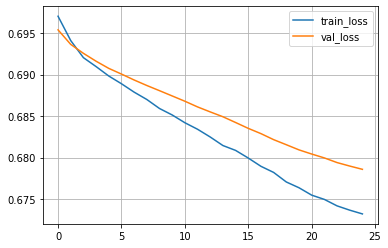

In [ ]:
for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()

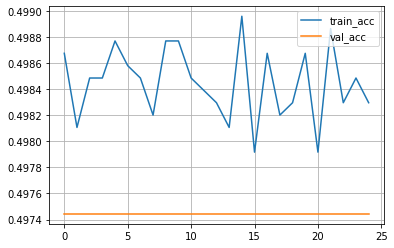

In [ ]:
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()

# Second set of features
Linguistic features obtained using the tone dictionary.

In [ ]:
features_2 = getTonality(df, ton_dict).values
data_2 = TorchDataset(features_2, target)

In [ ]:
classifier = MLPNet(features_2.shape[1])
train_state = train(classifier, data_2)

  0%|          | 0/25 [00:00<?, ?it/s]

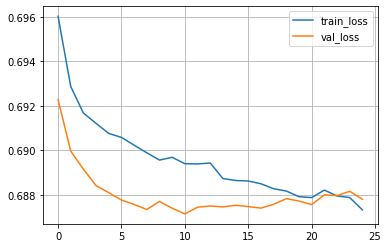

In [ ]:
for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()

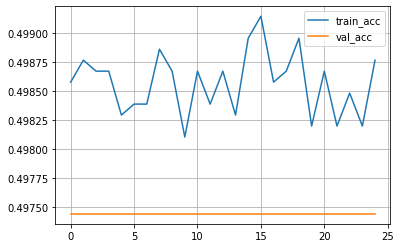

In [ ]:
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()

# Third set of features
Based on bag of words model with TF-IDF measure



In [ ]:
features_3 = getTfIdf(df)
data_3 = TorchDataset(features_3, target)

In [ ]:
classifier = MLPNet(features_3.shape[1])
train_state = train(classifier, data_3)

  0%|          | 0/25 [00:00<?, ?it/s]

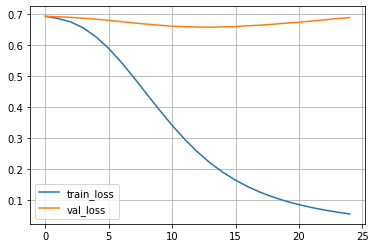

In [ ]:
for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()

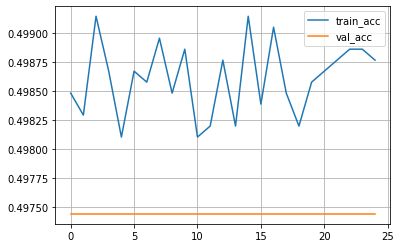

In [ ]:
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()